# Genetic Algorithm for solving TSP

          


















## Qu'est qu'un algorithm genetique ?

L'algorithme génétique appartient à la famille des algorithmes évolutionnistes ,se sont une famille d'algorithmes dont le principe s'inspire de la théorie de l'évolution pour résoudre des problèmes divers. L'idée est de faire évoluer un ensemble de solutions à un problème donné, dans l'optique de trouver les meilleurs résultats.

L'idée generale d'un l'algorithm genetic peut être répresenté comme suite:

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/07/22154007/steps.png "test")

![alt_text](https://cdn-images-1.medium.com/max/1000/1*vIrsxg12DSltpdWoO561yA.png "hehe")
## objectif de cet présentation

on va implémenter sous python cet algorithm pour résoudre un problème un classique d'algorithmique qu'est le problème du voyageur de commerce. 
Son sujet concerne les trajets d'un voyageur de commerce. Celui-ci doit s'arrêter en plusieurs points, et le but de l'algorithme est d'optimiser le trajet de façon que celui-ci soit le plus court possible. 

## Implémentation
Pour commencer , on a besoin faire la liaison entre chaque terme génétique et ce qu'il réprésente pour le problème du TSP

### 1-le gène
La classe City jouent le rôle du gène dans notre algorithm, une ville est représenté par un nom et des coordonnées. Une ville peut calculer sa distance par rapports aux autre ville


In [1]:
class City(object):
    
    def __init__(self , name , x , y ):
        self.name = name
        self.x=x 
        self.y=y 
        self.distances = {} # initiliasé le dictionnaire des distance local
        cities.append(self)     
    def Calculate_Distances(self):
        # calculer la distance euclidièene pour accéder à chaque cité
        x1,y1 = self.x , self.y
        for city in cities:
            x2,y2 = city.x , city.y
            self.distances[city.name] =  round(np.math.sqrt((x1-x2)**2 + (y1-y2)**2),1)

### 2- le chromosome

Path est une classe pour réprésenter les chemins dans notre TSP, ils jouent le rôle des chromosomes pour notre algorithme genétique 
Un chemin est une liste de ville parcourues de gauche à droite [A->B->C...->Z] , généré aléatoirement au départ. Ce qui nous interésse dans le chemin c'est sa distance totale qui jouera d'ailleur le rôle de la fitness qu'on essaie de minimiser

In [2]:
class Path(object):
   
    def __init__(self , path_to_decode = None ,size = None):
        
        if path_to_decode != None:
            self.path=[]
            for p in path_to_decode:
                self.path.append(cities[p])
        else:   
            #On initlialise un chemin au hasard et on intilalise sa longeur avec path_lenght()
            self.path = list(np.random.permutation(cities))
            self.path_lenght()
            if size != None:
                self.length = size
            
    def path_lenght(self): # fonction pour calculer la longeur d'un chemin
        self.length = 0
        for city in self.path:
            next_city_index = self.path.index(city) - len(cities) + 1 
            next_city = self.path[next_city_index]
            next_city_lenght = city.distances[next_city.name]
            self.length += next_city_lenght

### 3- la population

Population est une classe qui répresente notre population de chromosomes(i.e chemins),
elle contient un nombre prédefini de chromosomes au depart et reconnait le meilleur chemin ( celui avec la fitness minim)

In [3]:
class Population(object):
    
    def __init__(self , pop_size = None , cross_over_methode="ERX"):
        self.paths = []
        self.methode = cross_over_methode
        self.size=0
        
        if pop_size != None :
            self.size=pop_size
            for i in range(pop_size):
                #on crée pop_size route aléatoirement 
                self.paths.append(Path())
            # on tri les chemins par ordre croissant        
    def best_path(self, pos = None):
        if pos != None:    
            best = sorted(self.paths, key=lambda x: x.length, reverse=False)[pos]
        else:
            best = sorted(self.paths, key=lambda x: x.length, reverse=False)
        return best

##  Outils pour la genetic

Maintenant qu'on a representé les objet dont on a besoin pour résoudre le problème du TSP , on a besoin de représenter nos outils 

###  1- le crossover

il y a plusieurs moyens pour faire le crossover, le plus basic  :
![alt_text](http://www.abrandao.com/wp-content/uploads/2015/01/gene_crossover.gif "hehe")

après avoir tester plusieurs crossover j'ai choisi le "Genetic edge recombination crossover (ER)" developper par Whitley et al. (1989, 1991).

![alt_text](https://www.researchgate.net/publication/269524504/figure/fig2/AS:393506146275335@1470830584629/Example-of-the-steps-involved-in-edge-recombination-crossover-ER.jpg "EAX")



### 2- la mutation

comme pour le crossover , il y a plusieurs type de mutation , la plus basic consiste a "swaper" deux gènes aux hasard.

une meilleur mutation est l'application d'un 2-opt qui est un algorithme de recherche local qui s'énonse ainsi:
    
trouver une 2-permutation de $H$  produisant le cycle H tel que coût(H') < coût(H);
remplacer H par H′ ;
recommencer tant qu’une telle 2-permutation est possible.

![alt_text](http://i2.wp.com/www.saipanyam.net/wp-content/uploads/2011/06/Stochastic2opt.png? "hehe")


le 2-opt est en réalité qu'une specification du k-opt qui consiste à swaper $k$ edges 
![alt_text](https://www.researchgate.net/profile/Kamran_Zamanifar/publication/251985406/figure/fig2/AS:393200561868801@1470757727174/3-opt-move-seven-distinct-tour-are-obtained-from-original-tour-We-use-X-X-1-replace.jpg "hehe")

la mutation que j'ai choisi pour ce programme ce base sur l'heuristique de Lin-Kernighan qui consiste à faire un k-opt adaptatif en faisant un certain nombre de flips successifs.
je me suis restreint à faire des 2 ou 3-opt successive sur un point fix car au delas de 4-opt le temps calcules augumente d'une façon exponentiel $2^k$ 

![alt_text](https://media.giphy.com/media/1Be4dzHsXyVeJ5NoUU/giphy.gif)



In [4]:
class genetic_tools(object):

    def cross_over(PathA,PathB , method,PathC = None):
        child = Path()
        for n in range(length):
            child.path[n] = None
            
        if method == "basic":      
            random_cut = np.random.randint(0,length)

            for x in range(0,random_cut):
                child.path[x] = PathA.path[x]

            for i in range(random_cut, length):          
                if not PathB.path[i] in child.path:
                    child.path[i] = PathB.path[i]
                else:
                    for j in range(length):
                        if not PathB.path[j] in child.path:
                            child.path[i] = PathB.path[j]
                            break;
            child.path_lenght()
            return child
        
#--------------------------------------------------------------------------------------------------------------  

        if method == "two_cross_point":
            a,b = np.random.sample(range(length-1),2)
            first_cut = a
            second_cut = b
            if a > b :
                first_cut = b
                second_cut = a
            
            for x in range(0,first_cut):
                child.path[x] = PathA.path[x]
            for u in range(second_cut,length):
                child.path[u] = PathA.path[u]
            for i in range(first_cut, second_cut):          
                if not PathB.path[i] in child.path:
                    child.path[i] = PathB.path[i]
                else:
                    for j in range(length):
                        if not PathB.path[j] in child.path:
                            child.path[i] = PathB.path[j]
                            break;
            child.path_lenght()
            return child
 #--------------------------------------------------------------------------------------------------------------       
        if method == "2_cross_point_V2":
            first_cut = second_cut = 0
            while first_cut == second_cut: 
                first_cut = np.random.randint(0,length)
                second_cut = np.random.randint(0,length)
            if first_cut < second_cut:
                for x in range(0,first_cut):
                    child.path[x] = PathA.path[x]
                for u in range(second_cut,length):
                    child.path[u] = PathA.path[u]
                for i in range(first_cut, second_cut):          
                    if not PathB.path[i] in child.path:
                        child.path[i] = PathB.path[i]
                    else:
                        for j in range(length):
                            if not PathB.path[j] in child.path:
                                child.path[i] = PathB.path[j]
                                break;
            else:
                for x in range(0,second_cut):
                    child.path[x] = PathA.path[x]
                for u in range(first_cut,length):
                    child.path[u] = PathA.path[u]
                for i in range(second_cut, first_cut):          
                    if not PathB.path[i] in child.path:
                        child.path[i] = PathB.path[i]
                    else:
                        for j in range(length):
                            if not PathB.path[j] in child.path:
                                child.path[i] = PathB.path[j]
                                break;
            child.path_lenght()
            return child
 #------------------------------------------------------------------------------------------------------------       
        if method == "ERX":
            edges = {}
            pathA = PathA
            pathB = PathB
            for city in pathA.path : 
                Aneighbors=[]
                Bneighbors=[]
                next_city_index = pathA.path.index(city) - len(cities) + 1 
                next_city = pathA.path[next_city_index].name
                past_city_index = pathA.path.index(city)  - 1 
                past_city = pathA.path[past_city_index].name
                Aneighbors.append(next_city)
                Bneighbors.append(past_city)
                next_city_index = pathB.path.index(city) - len(cities) + 1 
                next_city = pathB.path[next_city_index].name
                past_city_index = pathB.path.index(city)  - 1 
                past_city = pathB.path[past_city_index].name
                Bneighbors.append(past_city)
                Bneighbors.append(next_city)
                neighbors = list(set(Aneighbors).union(Bneighbors))
                edges[city.name] = neighbors
                a = random.randint(0,length-1)
                choosen = str(a)
            child=[]
            for i in range(length): 
                min = 5
                child.append(int(choosen))
                for j in range(length):
                    if choosen in edges[str(j)]:
                        edges[str(j)].remove(choosen)
                for k in edges[choosen]:
                    if len(edges[k])<=min:
                        min = len(edges[k])
                        choosen = k
                if len(edges[choosen]) == 0:
                    for p in range(length):
                        min = 5
                        for l in edges[str(p)] :
                            if l not in child and len(edges[str(p)]) <= min:
                                choosen = l
                                min = len(edges[str(p)])
                                            
            child2=Path(path_to_decode=child)   
            child2.path_lenght()
            return child2
            
        
                            
    def mutation(Path , methode = "linK-opt"):
                swaps = random.randint(1,29)
                k = np.arange(length)
                random.shuffle(k)
                Ay = list(k)
                i1 = Ay.pop()
                a = Path.path[i1] # choose fixed city
                for _ in range(swaps): # do subsequential 2-opt or 3-opt on that fixed point 
                    OPT = random.randint(2,3)
                    if OPT == 2:
                        i2 , iDel = random.sample(Ay , 2)
                        b = Path.path[i2]
                        i3 = i1 - len(cities) + 1
                        i4 = i2 - len(cities) + 1
                        c = Path.path[i3]
                        d = Path.path[i4]
                        if d != a and a.distances[c.name] +  b.distances[d.name] > a.distances[d.name] +  b.distances[c.name]:
                            Path.path[i3] , Path.path[i4]  = Path.path[i4] , Path.path[i3]  
                            Path.path_lenght()
                            
                    elif OPT == 3:  
                        i20,i30 = random.sample(Ay , 2)
                        b = Path.path[i20]
                        c = Path.path[i30]
                        i40 = i1 - len(cities) + 1
                        i50 = i20 - len(cities) + 1
                        i60 = i30 - len(cities) + 1
                        x = Path.path[i40]
                        y = Path.path[i50]
                        z = Path.path[i60]
                        if a != y and a != z: 
                            if(a.distances[x.name] +  b.distances[y.name] + c.distances[z.name] > a.distances[y.name] +  b.distances[z.name] + c.distances[x.name]) :
                                Path.path[i40] , Path.path[i50] , Path.path[i60] = Path.path[i50] , Path.path[i60] ,Path.path[i40]  
                                Path.path_lenght()
                                
            

## Methodes de selection


Pour générer une nouvelle population on a besoin d'une méthode de selection , il existe plusieurs methode de selection ; les plus connues étant :

### 1- Méthode de tournoi :

elle consiste à tirer au hasard $n < $pop_size chromosome de la population et de voir qui d'entre eux à la meilleur fitness (i.e le chemin le plus court ).
plus on augumente n , plus on favorise la survi des meilleur chromosome et plus on augumente le temps d'execution



### 2- Méthode de la roulette

elle consiste à affecter à chaque chromosome une probabilité proportionelle à sa fitness. 

### 3- Elitism 

il suffit tout simplement de prendre les $n$ meilleurs chromosome sans laisser de chance aux autres 






In [5]:
class Selection(object):
    
    def Survivor(POP):
        fighters = Population()
        for _ in range(Survival_rate):
            fighters.paths.append(random.choice(POP.paths))
        return fighters.best_path(0)
   
    def Generate_new_era(population):
        #on crée une nouvelle population aléatoirement
        methode = cross_over_default
        new_era = Population()
        new_era.size = population.size
        elite = 0
        bests = population.best_path()
        while elite < ELIT_NUM :       
            #on remplace le premier element par le meilleur element de notre ancienne population
            new_era.paths.append(bests[elite])
            #print("appended %d" %(new_era.best_path(self.elite).length))
            elite += 1
        for chromosome in range(elite,POP_SIZE):
            do_cross = random.random()
            do_mut = random.random()
            path_to_evolve = Selection.Survivor(population)
            if  do_cross < cross_over_probability:
                #p3 = Path(1)
                p1 = Selection.Survivor(population)
                p2 = Selection.Survivor(population)
                #p3 = self.Survivor(population)
                if p1 != p2:
                    path_to_evolve = genetic_tools.cross_over(p1,p2,methode)      
            if do_mut < MUT_PROB:
                genetic_tools.mutation(path_to_evolve)      
            new_era.paths.append(path_to_evolve)
        
        return new_era
    def migrate(population):
        print("migration...")
        new_island = Population(POP_SIZE)
        for chromosome in range(1,POP_SIZE):
            do_mut = random.random()
            p1 = population.best_path(0)
            p2 = new_island.paths[chromosome]
            path_to_evolve = genetic_tools.cross_over(p1,p2,cross_over_default)  
            if  do_mut < MUT_PROB:
                genetic_tools.mutation(path_to_evolve)
            new_island.paths[chromosome] = path_to_evolve
        migrated_island = Population()
        Winners = new_island.best_path()
        migrated_island.paths= Winners[:population.size]
        return new_island

# Exemples 

on va voir désormais la performance de ce programme sur des instances de 29 ,51 et 280 villes 
pour celà on va rassembler toute nos classe dans une classe d'application finale 



In [6]:
class Applied_Genetics(object):    
    def Multi_Population_GA(self,generations = 100 , v = 50 , m = 0 , cv = 20 , cd = 20):  
        global cross_over_probability
        global MUT_PROB
        global ELIT_NUM
        global Survival_rate
        global POP_SIZE
        global convergence_limite
        global swaps 
        global POP_SIZE     
        global cross_over_default
        cross_over_default = "ERX"
        self.changelen = []
        self.changepath = []
        self.density = {}
        convergence=[]
        cooldown = cd
        migrated = 0
        alpha = cv
        Evolved_population = Population(POP_SIZE) 
        for k in range(generations+1):
            Evolved_population = Selection.Generate_new_era(Evolved_population)
            if m ==1 :
                convergence.append(Evolved_population.best_path(0).length)   
                if k >30:
                    IND = k-alpha
                    convergence_test = convergence[IND]-convergence[k]
                    if convergence_test <= 0 and cooldown >= cd:
                        cross_over_probability = 1
                        MUT_PROB = 1
                        Evolved_population = Selection.migrate(Evolved_population )
                        migrated = 1
                        cooldown = 0 
                    if migrated == 1:
                        cooldown += 1
            T = Evolved_population.best_path()
            density = []
            for i in range(POP_SIZE):
                density.append(T[i].length)
            self.changepath.append(Evolved_population.best_path(0))
            self.changelen.append(Evolved_population.best_path(0).length-10)
            self.density[k]=density
            if k % v == 0:
                print("%dth generation best path is =: %.2f " % (k,self.changepath[k].length))
        self.Best_path = sorted(self.changepath , key=lambda x: x.length, reverse=False)[0]
        return self

In [7]:
import numpy as np
import random
import pandas as pd
a280 = pd.read_csv('a280.tsp', delim_whitespace=True , index_col=0 , header=None)
e51 =  pd.read_csv('eil51.tsp', delim_whitespace=True , index_col=0 , header=None)
i29=[[0.000000,107.000000,241.000000,190.000000,124.000000,80.000000,316.000000,76.000000,152.000000,157.000000,283.000000,133.000000,113.000000,297.000000,228.000000,129.000000,348.000000,276.000000,188.000000,150.000000,65.000000,341.000000,184.000000,67.000000,221.000000,169.000000,108.000000,45.000000,167.000000],
[107.000000,0.000000,148.000000,137.000000,88.000000,127.000000,336.000000,183.000000,134.000000,95.000000,254.000000,180.000000,101.000000,234.000000,175.000000,176.000000,265.000000,199.000000,182.000000,67.000000,42.000000,278.000000,271.000000,146.000000,251.000000,105.000000,191.000000,139.000000,79.000000],
[241.000000,148.000000,0.000000,374.000000,171.000000,259.000000,509.000000,317.000000,217.000000,232.000000,491.000000,312.000000,280.000000,391.000000,412.000000,349.000000,422.000000,356.000000,355.000000,204.000000,182.000000,435.000000,417.000000,292.000000,424.000000,116.000000,337.000000,273.000000,77.000000],
[190.000000,137.000000,374.000000,0.000000,202.000000,234.000000,222.000000,192.000000,248.000000,42.000000,117.000000,287.000000,79.000000,107.000000,38.000000,121.000000,152.000000,86.000000,68.000000,70.000000,137.000000,151.000000,239.000000,135.000000,137.000000,242.000000,165.000000,228.000000,205.000000],
[124.000000,88.000000,171.000000,202.000000,0.000000,61.000000,392.000000,202.000000,46.000000,160.000000,319.000000,112.000000,163.000000,322.000000,240.000000,232.000000,314.000000,287.000000,238.000000,155.000000,65.000000,366.000000,300.000000,175.000000,307.000000,57.000000,220.000000,121.000000,97.000000],
[80.000000,127.000000,259.000000,234.000000,61.000000,0.000000,386.000000,141.000000,72.000000,167.000000,351.000000,55.000000,157.000000,331.000000,272.000000,226.000000,362.000000,296.000000,232.000000,164.000000,85.000000,375.000000,249.000000,147.000000,301.000000,118.000000,188.000000,60.000000,185.000000],
[316.000000,336.000000,509.000000,222.000000,392.000000,386.000000,0.000000,233.000000,438.000000,254.000000,202.000000,439.000000,235.000000,254.000000,210.000000,187.000000,313.000000,266.000000,154.000000,282.000000,321.000000,298.000000,168.000000,249.000000,95.000000,437.000000,190.000000,314.000000,435.000000],
[76.000000,183.000000,317.000000,192.000000,202.000000,141.000000,233.000000,0.000000,213.000000,188.000000,272.000000,193.000000,131.000000,302.000000,233.000000,98.000000,344.000000,289.000000,177.000000,216.000000,141.000000,346.000000,108.000000,57.000000,190.000000,245.000000,43.000000,81.000000,243.000000],
[152.000000,134.000000,217.000000,248.000000,46.000000,72.000000,438.000000,213.000000,0.000000,206.000000,365.000000,89.000000,209.000000,368.000000,286.000000,278.000000,360.000000,333.000000,284.000000,201.000000,111.000000,412.000000,321.000000,221.000000,353.000000,72.000000,266.000000,132.000000,111.000000],
[157.000000,95.000000,232.000000,42.000000,160.000000,167.000000,254.000000,188.000000,206.000000,0.000000,159.000000,220.000000,57.000000,149.000000,80.000000,132.000000,193.000000,127.000000,100.000000,28.000000,95.000000,193.000000,241.000000,131.000000,169.000000,200.000000,161.000000,189.000000,163.000000],
[283.000000,254.000000,491.000000,117.000000,319.000000,351.000000,202.000000,272.000000,365.000000,159.000000,0.000000,404.000000,176.000000,106.000000,79.000000,161.000000,165.000000,141.000000,95.000000,187.000000,254.000000,103.000000,279.000000,215.000000,117.000000,359.000000,216.000000,308.000000,322.000000],
[133.000000,180.000000,312.000000,287.000000,112.000000,55.000000,439.000000,193.000000,89.000000,220.000000,404.000000,0.000000,210.000000,384.000000,325.000000,279.000000,415.000000,349.000000,285.000000,217.000000,138.000000,428.000000,310.000000,200.000000,354.000000,169.000000,241.000000,112.000000,238.000000],
[113.000000,101.000000,280.000000,79.000000,163.000000,157.000000,235.000000,131.000000,209.000000,57.000000,176.000000,210.000000,0.000000,186.000000,117.000000,75.000000,231.000000,165.000000,81.000000,85.000000,92.000000,230.000000,184.000000,74.000000,150.000000,208.000000,104.000000,158.000000,206.000000],
[297.000000,234.000000,391.000000,107.000000,322.000000,331.000000,254.000000,302.000000,368.000000,149.000000,106.000000,384.000000,186.000000,0.000000,69.000000,191.000000,59.000000,35.000000,125.000000,167.000000,255.000000,44.000000,309.000000,245.000000,169.000000,327.000000,246.000000,335.000000,288.000000],
[228.000000,175.000000,412.000000,38.000000,240.000000,272.000000,210.000000,233.000000,286.000000,80.000000,79.000000,325.000000,117.000000,69.000000,0.000000,122.000000,122.000000,56.000000,56.000000,108.000000,175.000000,113.000000,240.000000,176.000000,125.000000,280.000000,177.000000,266.000000,243.000000],
[129.000000,176.000000,349.000000,121.000000,232.000000,226.000000,187.000000,98.000000,278.000000,132.000000,161.000000,279.000000,75.000000,191.000000,122.000000,0.000000,244.000000,178.000000,66.000000,160.000000,161.000000,235.000000,118.000000,62.000000,92.000000,277.000000,55.000000,155.000000,275.000000],
[348.000000,265.000000,422.000000,152.000000,314.000000,362.000000,313.000000,344.000000,360.000000,193.000000,165.000000,415.000000,231.000000,59.000000,122.000000,244.000000,0.000000,66.000000,178.000000,198.000000,286.000000,77.000000,362.000000,287.000000,228.000000,358.000000,299.000000,380.000000,319.000000],
[276.000000,199.000000,356.000000,86.000000,287.000000,296.000000,266.000000,289.000000,333.000000,127.000000,141.000000,349.000000,165.000000,35.000000,56.000000,178.000000,66.000000,0.000000,112.000000,132.000000,220.000000,79.000000,296.000000,232.000000,181.000000,292.000000,233.000000,314.000000,253.000000],
[188.000000,182.000000,355.000000,68.000000,238.000000,232.000000,154.000000,177.000000,284.000000,100.000000,95.000000,285.000000,81.000000,125.000000,56.000000,66.000000,178.000000,112.000000,0.000000,128.000000,167.000000,169.000000,179.000000,120.000000,69.000000,283.000000,121.000000,213.000000,281.000000],
[150.000000,67.000000,204.000000,70.000000,155.000000,164.000000,282.000000,216.000000,201.000000,28.000000,187.000000,217.000000,85.000000,167.000000,108.000000,160.000000,198.000000,132.000000,128.000000,0.000000,88.000000,211.000000,269.000000,159.000000,197.000000,172.000000,189.000000,182.000000,135.000000],
[65.000000,42.000000,182.000000,137.000000,65.000000,85.000000,321.000000,141.000000,111.000000,95.000000,254.000000,138.000000,92.000000,255.000000,175.000000,161.000000,286.000000,220.000000,167.000000,88.000000,0.000000,299.000000,229.000000,104.000000,236.000000,110.000000,149.000000,97.000000,108.000000],
[341.000000,278.000000,435.000000,151.000000,366.000000,375.000000,298.000000,346.000000,412.000000,193.000000,103.000000,428.000000,230.000000,44.000000,113.000000,235.000000,77.000000,79.000000,169.000000,211.000000,299.000000,0.000000,353.000000,289.000000,213.000000,371.000000,290.000000,379.000000,332.000000],
[184.000000,271.000000,417.000000,239.000000,300.000000,249.000000,168.000000,108.000000,321.000000,241.000000,279.000000,310.000000,184.000000,309.000000,240.000000,118.000000,362.000000,296.000000,179.000000,269.000000,229.000000,353.000000,0.000000,121.000000,162.000000,345.000000,80.000000,189.000000,342.000000],
[67.000000,146.000000,292.000000,135.000000,175.000000,147.000000,249.000000,57.000000,221.000000,131.000000,215.000000,200.000000,74.000000,245.000000,176.000000,62.000000,287.000000,232.000000,120.000000,159.000000,104.000000,289.000000,121.000000,0.000000,154.000000,220.000000,41.000000,93.000000,218.000000],
[221.000000,251.000000,424.000000,137.000000,307.000000,301.000000,95.000000,190.000000,353.000000,169.000000,117.000000,354.000000,150.000000,169.000000,125.000000,92.000000,228.000000,181.000000,69.000000,197.000000,236.000000,213.000000,162.000000,154.000000,0.000000,352.000000,147.000000,247.000000,350.000000],
[169.000000,105.000000,116.000000,242.000000,57.000000,118.000000,437.000000,245.000000,72.000000,200.000000,359.000000,169.000000,208.000000,327.000000,280.000000,277.000000,358.000000,292.000000,283.000000,172.000000,110.000000,371.000000,345.000000,220.000000,352.000000,0.000000,265.000000,178.000000,39.000000],
[108.000000,191.000000,337.000000,165.000000,220.000000,188.000000,190.000000,43.000000,266.000000,161.000000,216.000000,241.000000,104.000000,246.000000,177.000000,55.000000,299.000000,233.000000,121.000000,189.000000,149.000000,290.000000,80.000000,41.000000,147.000000,265.000000,0.000000,124.000000,263.000000],
[45.000000,139.000000,273.000000,228.000000,121.000000,60.000000,314.000000,81.000000,132.000000,189.000000,308.000000,112.000000,158.000000,335.000000,266.000000,155.000000,380.000000,314.000000,213.000000,182.000000,97.000000,379.000000,189.000000,93.000000,247.000000,178.000000,124.000000,0.000000,199.000000],
[167.000000,79.000000,77.000000,205.000000,97.000000,185.000000,435.000000,243.000000,111.000000,163.000000,322.000000,238.000000,206.000000,288.000000,243.000000,275.000000,319.000000,253.000000,281.000000,135.000000,108.000000,332.000000,342.000000,218.000000,350.000000,39.000000,263.000000,199.000000,0.000000],
];


In [9]:
cities = []
for i in range(0,len(i29)):
    name = str(i)
    City(name,0,0)
    for j in range(0,len(i29)):
         cities[i].distances[str(j)]=i29[i][j]
length = len(cities)
POP_SIZE = 500
MUT_PROB = 0.5
cross_over_probability = 1
ELIT_NUM = int(POP_SIZE*0.4)
Survival_rate = 5
EvolvedPopulation= Applied_Genetics().Multi_Population_GA(40,10,0,0,0)
print ("best path found : %d , optimal = 2020 , error = %f percent " % (EvolvedPopulation.Best_path.length,(1-2020/EvolvedPopulation.Best_path.length)*100)) 


0th generation best path is =: 3882.00 
10th generation best path is =: 2567.00 
20th generation best path is =: 2246.00 
30th generation best path is =: 2070.00 
40th generation best path is =: 2031.00 
best path found : 2031 , optimal = 2020 , error = 0.541605 percent 


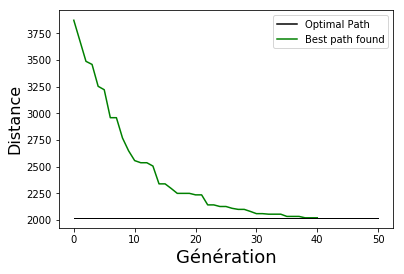

In [10]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


%matplotlib inline
plt.plot(EvolvedPopulation.changelen , color='G')
blue_line = mlines.Line2D([], [], color='G', marker='',
                          markersize=15, label='Best path found')
black_line = mlines.Line2D([], [], color='BLACK', marker='',
                          markersize=15, label='Optimal Path')
plt.legend(handles=[black_line,blue_line])
plt.xlabel('Génération', fontsize=18)
plt.ylabel('Distance', fontsize=16)
plt.plot([50, 0], [2020, 2020], 'BLACK', lw=1)

In [54]:
cities = []
for i in range(len(e51)):
    name = str(i)
    x = e51.iloc[i,0]
    y = e51.iloc[i,1]
    City(name,x,y)
for city in cities:    
    city.Calculate_Distances()
length = len(cities)

POP_SIZE = 500
MUT_PROB = 0.5
cross_over_probability = 0.6
ELIT_NUM = int(POP_SIZE*0.4)
Survival_rate = 5
%time EPopulation= Applied_Genetics().Multi_Population_GA(generations=100,v=5,m=0,cv=10,cd=100)
print ("best path found : %d , optimal = 430 , error = %f " % (EPopulation.Best_path.length,(1-430/EPopulation.Best_path.length)*10)) 


0th generation best path is =: 1247.70 
5th generation best path is =: 955.70 
10th generation best path is =: 828.60 
15th generation best path is =: 729.90 
20th generation best path is =: 684.50 
25th generation best path is =: 641.50 
30th generation best path is =: 600.10 
35th generation best path is =: 581.10 
40th generation best path is =: 567.00 
45th generation best path is =: 517.70 
50th generation best path is =: 535.70 
55th generation best path is =: 515.10 
60th generation best path is =: 501.80 
65th generation best path is =: 469.90 
70th generation best path is =: 467.10 
75th generation best path is =: 457.50 
80th generation best path is =: 447.60 
85th generation best path is =: 445.60 
90th generation best path is =: 445.60 
95th generation best path is =: 445.60 
100th generation best path is =: 445.60 
Wall time: 27.8 s
best path found : 445 , optimal = 430 , error = 0.350090 


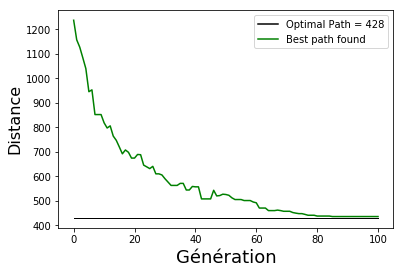

In [55]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


%matplotlib inline
plt.plot(EPopulation.changelen , color='G')
blue_line = mlines.Line2D([], [], color='G', marker='',
                          markersize=15, label='Best path found')
black_line = mlines.Line2D([], [], color='BLACK', marker='',
                          markersize=15, label='Optimal Path = 428')
plt.legend(handles=[black_line,blue_line])
plt.xlabel('Génération', fontsize=18)
plt.ylabel('Distance', fontsize=16)
plt.plot([100, 0], [430, 430], 'BLACK', lw=1)

In [46]:


trials.append(430)


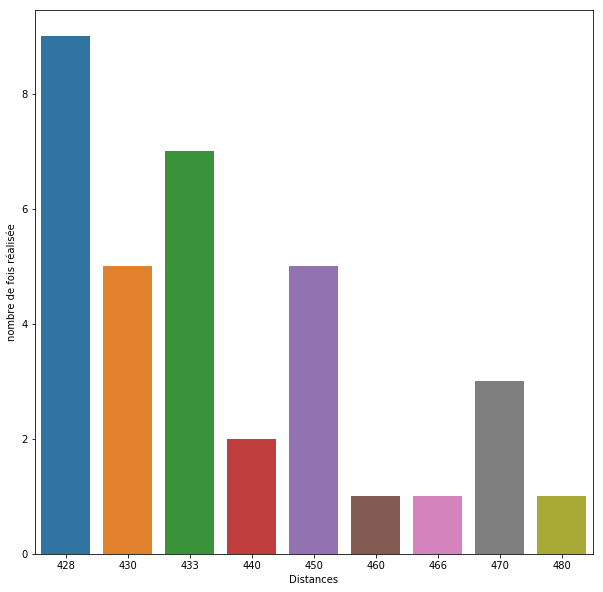

(15.343500590824208, 440.55882352941177)

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
stats = np.array(trials)
plt.figure(figsize=(10,10))
ax=sns.countplot(stats)
ax.set(xlabel='Distances', ylabel='nombre de fois réalisée' )
plt.show()
stats.std() , stats.mean()

In [310]:
cities = []
for i in range(len(a280)):
    name = str(i)
    x = a280.iloc[i,0]
    y = a280.iloc[i,1]
    City(name,x,y)
for city in cities:    
    city.Calculate_Distances()
length = len(cities)

POP_SIZE = 100
MUT_PROB = 0.3
cross_over_probability = 0.7
ELIT_NUM = int(POP_SIZE*0.4)
Survival_rate = 5
%time EPopulation= Applied_Genetics().Multi_Population_GA(generations=1000,v=1,m=1,cv=20,cd=1000)
print ("best path found : %d " % EPopulation.Best_path.length) 

0th generation best path is =: 31103.60 
1th generation best path is =: 30298.90 
2th generation best path is =: 29417.00 
3th generation best path is =: 29024.90 
4th generation best path is =: 28661.50 
5th generation best path is =: 27947.10 
6th generation best path is =: 27166.30 
7th generation best path is =: 25923.20 
8th generation best path is =: 25629.50 
9th generation best path is =: 25386.80 
10th generation best path is =: 24768.30 
11th generation best path is =: 24448.90 
12th generation best path is =: 24014.50 
13th generation best path is =: 24014.50 
14th generation best path is =: 23699.60 
15th generation best path is =: 22775.90 
16th generation best path is =: 23019.70 
17th generation best path is =: 22271.00 
18th generation best path is =: 22848.90 
19th generation best path is =: 23195.40 
20th generation best path is =: 23391.30 
21th generation best path is =: 22967.30 
22th generation best path is =: 23472.20 
23th generation best path is =: 23161.30 
24

KeyboardInterrupt: 

best path found : 22702 


In [20]:
%timeit a.best_path()

15.6 µs ± 214 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
